# Hexapawn

## Broi razgraneti jazli

### Bez alfa beta potskratuvanje

Ai vs Ai

In [16]:
from plotly import graph_objects as go
import ipywidgets as widgets
from collections import deque
from copy import deepcopy
import time

In [17]:
node_count = 0

In [18]:
def minimaxRoot(depth, board, player):
    global moves, node_count
    moves = board.available_moves()
    scores = {}
    bestMove = -9999 if player else 9999

    for move in moves:
        board.push(move)
        value, node_count = minimax(depth - 1, board, -10000, 10000, not player, node_count)
        scores[move] = value
        board.pop()
        if player and value >= bestMove:
            bestMove = value
            bestMoveFound = move
        elif not player and value <= bestMove:
            bestMove = value
            bestMoveFound = move
    
    return bestMoveFound, moves, scores, node_count

def minimax(depth, board, alpha, beta, player, node_count):
    node_count += 1  # Increment the node count

    if depth == 0:
        return board.score(), node_count

    moves = board.available_moves()

    if player:
        bestMove = -9999
        for move in moves:
            board.push(move)
            value, node_count = minimax(depth - 1, board, alpha, beta, not player, node_count)
            bestMove = max(bestMove, value)
            board.pop()
            alpha = max(alpha, bestMove)
            if beta <= alpha:
                break
        return bestMove, node_count
    else:
        bestMove = 9999
        for move in moves:
            board.push(move)
            value, node_count = minimax(depth - 1, board, alpha, beta, not player, node_count)
            bestMove = min(bestMove, value)
            board.pop()
            beta = min(beta, bestMove)
            if beta <= alpha:
                break
        return bestMove, node_count

In [19]:

class Board:
    def __init__(self, table, turn=True):
        self.table = deepcopy(table)
        self.queue = []
        self.turn = turn 
        
    def push(self, move):
        self.queue.append(move)
        self.update_table()
        self.turn = not self.turn
        
    def pop(self):
        move = self.queue.pop()
        self.update_table(move)
        self.turn = not self.turn
        return move
        
    def peek(self):
        return self.queue[-1]
    
    def update_table(self, move=None):
        if move is not None:
            old, new = move
            self.table[old[0]][old[1]] = not self.turn
            self.table[new[0]][new[1]] = None if old[1] == new[1] else self.turn
        else:
            old, new = self.peek()
            self.table[old[0]][old[1]] = None
            self.table[new[0]][new[1]] = self.turn
            
    def legal_moves(self, x, y):
        x += -1 if self.turn else 1
        moves = []
        for i in range(-1, 2):
            if 0 <= x < M and 0 <= y + i < N:
                if self.table[x][y + i] is None and i == 0:
                    moves.append((x, y))
                elif self.table[x][y + i] == (not self.turn) and i != 0:
                    moves.append((x, y + i))
        return moves
    
    def available_moves(self):
        moves = []
        for x in range(M):
            for y in range(N):
                if self.table[x][y] == self.turn:
                    for move in self.legal_moves(x, y):
                        moves.append(((x, y), move))
        return moves
    
    def score(self):
        score = 0
        for x in range(M):
            for y in range(N):
                if self.table[x][y] is not None:
                    score += M - x if self.table[x][y] else -(x + 1)
                    if x == 0 and self.table[x][y]:
                        return 9999
                    elif x == M - 1 and not self.table[x][y]:
                        return -9999
        score += len([i for row in self.table for i in row if i]) - len([i for row in self.table for i in row if i is False])
        return score

In [20]:
def posible_moves(x, y):
    moves = []
    if TABLE[x][y] is None:
        return moves
    for i in range(-1, 2):
        if 0 <= x - 1 < M and 0 <= y + i < N:
            if TABLE[x - 1][y + i] is None and i == 0:
                moves.append((x - 1, y))
            elif TABLE[x - 1][y + i] is False and i != 0:
                moves.append((x - 1, y + i))
    return moves

def game_end(board):
    if False in board.table[M - 1]:
        return "Red"
    elif True in board.table[0]:
        return "Blue"
    if not board.available_moves():
        return "Red" if board.turn else "Blue"
    return None

In [21]:
debug = True

def update_fig(trace, points, selector):
    global TABLE, node_count
    
    board = Board(TABLE)
    move, moves, scores, node_count = minimaxRoot(4, board, True)
    if debug: 
        print(f"AI (Blue) move: {move}, Scores: {scores}, Node count: {node_count}")

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) is not None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !! Nodes evaluated: {node_count}'
        fig.data[0].on_click(None)
        return 
    
    time.sleep(1) # AI Part
    board = Board(TABLE, False)
    move, moves, scores, node_count =minimaxRoot(5, board, False)
    if debug: 
        print(f"AI (Red) move: {move}, Scores: {scores}, Node count: {node_count}")

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) is not None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !! Nodes evaluated: {node_count}'
        fig.data[0].on_click(None)
        return
    
def create_fig():
    fig = go.FigureWidget()
    x = [x for y in range(M) for x in range(N)]
    y = [y for y in range(M) for x in range(N)]
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.add_scatter(x=x, y=y, mode='markers', marker_size=(M + 1) * 10 + N + 2, 
        marker_symbol='square', marker_color=colors, hoverinfo='none')
    fig.data[0].on_click(update_fig)
    fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, side='top', visible=False, autorange=False)
    fig.update_yaxes(range=[-0.5, M - 0.5], dtick=1, autorange='reversed', visible=False)
    fig.update_layout(width=80 * N, height=80 * N, showlegend=False, margin={'r':0, 'l':0, 't':0, 'b':0}, plot_bgcolor='#212121')

    return fig

N = 6
M = 5
TABLE = [
    [False,] * N,
    [None,] * N,
    [None,] * N,
    [None,] * N,
    [True,] * N,
]
fig = create_fig()
text = widgets.HTML(value='<font size=4> Hexapawn')
display(widgets.VBox([fig, text]))
node_count = 0


    'data': [{'hoverinfo': 'none',
              'marker': {'color': [#d62728, #…

### So alfa beta potskratuvanje

In [22]:
from plotly import graph_objects as go
import ipywidgets as widgets
from collections import deque
from copy import deepcopy
import time

In [15]:
node_count = 0

In [16]:
def minimaxAlphaBeta(depth, board, alpha, beta, player, node_count):
    node_count+=1
    if depth == 0:
        return board.score(), node_count

    moves = board.available_moves()
    if player:
        bestMove = -9999
        for move in moves:
            board.push(move)
            value, node_count = minimaxAlphaBeta(depth - 1, board, alpha, beta, not player, node_count )
            bestMove = max(bestMove, value)
            board.pop()
            alpha = max(alpha, bestMove)
            if beta <= alpha:
                break
        return bestMove, node_count
    else:
        bestMove = 9999
        for move in moves:
            board.push(move)
            value, node_count = minimaxAlphaBeta(depth - 1, board, alpha, beta, not player, node_count )
            bestMove = min(bestMove, value)
            board.pop()
            beta = min(beta, bestMove)
            if beta <= alpha:
                break
        return bestMove, node_count

def minimaxAlphaBetaRoot(depth, board, player):
    global moves,node_count
    moves = board.available_moves()
    scores = {}
    bestMove = -9999 if player else 9999
    alpha = -10000
    beta = 10000
    node_count = 0

    for move in moves:
        board.push(move)
        value, node_count = minimaxAlphaBeta(depth - 1, board, alpha, beta, not player, node_count )
        scores[move] = value
        board.pop()
        if player and value >= bestMove:
            bestMove = value
            bestMoveFound = move
        elif not player and value <= bestMove:
            bestMove = value
            bestMoveFound = move

    return bestMoveFound, moves, scores, node_count


In [17]:

class Board:
    def __init__(self, table, turn=True):
        self.table = deepcopy(table)
        self.queue = []
        self.turn = turn 
        
    def push(self, move):
        self.queue.append(move)
        self.update_table()
        self.turn = not self.turn
        
    def pop(self):
        move = self.queue.pop()
        self.update_table(move)
        self.turn = not self.turn
        return move
        
    def peek(self):
        return self.queue[-1]
    
    def update_table(self, move=None):
        if move is not None:
            old, new = move
            self.table[old[0]][old[1]] = not self.turn
            self.table[new[0]][new[1]] = None if old[1] == new[1] else self.turn
        else:
            old, new = self.peek()
            self.table[old[0]][old[1]] = None
            self.table[new[0]][new[1]] = self.turn
            
    def legal_moves(self, x, y):
        x += -1 if self.turn else 1
        moves = []
        for i in range(-1, 2):
            if 0 <= x < M and 0 <= y + i < N:
                if self.table[x][y + i] is None and i == 0:
                    moves.append((x, y))
                elif self.table[x][y + i] == (not self.turn) and i != 0:
                    moves.append((x, y + i))
        return moves
    
    def available_moves(self):
        moves = []
        for x in range(M):
            for y in range(N):
                if self.table[x][y] == self.turn:
                    for move in self.legal_moves(x, y):
                        moves.append(((x, y), move))
        return moves
    
    def score(self):
        score = 0
        for x in range(M):
            for y in range(N):
                if self.table[x][y] is not None:
                    score += M - x if self.table[x][y] else -(x + 1)
                    if x == 0 and self.table[x][y]:
                        return 9999
                    elif x == M - 1 and not self.table[x][y]:
                        return -9999
        score += len([i for row in self.table for i in row if i]) - len([i for row in self.table for i in row if i is False])
        return score

In [18]:
def posible_moves(x, y):
    moves = []
    if TABLE[x][y] is None:
        return moves
    for i in range(-1, 2):
        if 0 <= x - 1 < M and 0 <= y + i < N:
            if TABLE[x - 1][y + i] is None and i == 0:
                moves.append((x - 1, y))
            elif TABLE[x - 1][y + i] is False and i != 0:
                moves.append((x - 1, y + i))
    return moves

def game_end(board):
    if False in board.table[M - 1]:
        return "Red"
    elif True in board.table[0]:
        return "Blue"
    if not board.available_moves():
        return "Red" if board.turn else "Blue"
    return None

In [19]:
debug = True

def update_fig(trace, points, selector):
    global TABLE, node_count
    
    board = Board(TABLE)
    move, moves, scores, node_count = minimaxAlphaBetaRoot(4, board, True)
    if debug: 
        print(f"AI (Blue) move: {move}, Scores: {scores}, Node count: {node_count}")

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) is not None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !! Nodes evaluated: {node_count}'
        fig.data[0].on_click(None)
        return 
    
    time.sleep(1) # AI Part
    board = Board(TABLE, False)
    move, moves, scores, node_count =minimaxAlphaBetaRoot(5, board, False)
    if debug: 
        print(f"AI (Red) move: {move}, Scores: {scores}, Node count: {node_count}")

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) is not None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !! Nodes evaluated: {node_count}'
        fig.data[0].on_click(None)
        return
    
def create_fig():
    fig = go.FigureWidget()
    x = [x for y in range(M) for x in range(N)]
    y = [y for y in range(M) for x in range(N)]
    colors = ['#121212' if n is None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.add_scatter(x=x, y=y, mode='markers', marker_size=(M + 1) * 10 + N + 2, 
        marker_symbol='square', marker_color=colors, hoverinfo='none')
    fig.data[0].on_click(update_fig)
    fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, side='top', visible=False, autorange=False)
    fig.update_yaxes(range=[-0.5, M - 0.5], dtick=1, autorange='reversed', visible=False)
    fig.update_layout(width=80 * N, height=80 * N, showlegend=False, margin={'r':0, 'l':0, 't':0, 'b':0}, plot_bgcolor='#212121')

    return fig

N = 6
M = 5
TABLE = [
    [False,] * N,
    [None,] * N,
    [None,] * N,
    [None,] * N,
    [True,] * N,
]
fig = create_fig()
text = widgets.HTML(value='<font size=4> Hexapawn')
display(widgets.VBox([fig, text]))
node_count = 0


    'data': [{'hoverinfo': 'none',
              'marker': {'color': [#d62728, #…

# Evristika

## Originalna

In [1]:
import numpy as np  # Импортирање на numpy библиотеката за работа со 2D низи.

def evaluate_state_hexapawn(board, player):
    """
    Евристичка функција за Hexapawn.
    
    Parameters:
    - board: numpy 2D array што ја претставува таблата.
    - player: 'W' или 'B' за бел или црн играч.
    
    Returns:
    - Вредност на евристиката за дадената состојба.
    """
    n, m = board.shape  # Добиј ги димензиите на таблата.
    opponent = 'W' if player == 'B' else 'B'  # Определи го противникот.

    # 1. **Прогрес на пионите:**
    progress_score = 0
    for x in range(n):
        for y in range(m):
            if board[x, y] == player:  # Ако полето има пион на тековниот играч,
                progress_score += (n - 1 - x) if player == 'W' else x  # додади поени за напредок.
            elif board[x, y] == opponent:  # Ако полето има пион на противникот,
                progress_score -= (n - 1 - x) if opponent == 'W' else x  # одземи поени за напредок на противникот.

    # 2. **Мобилност:**
    def pawn_moves(px, py, pl):
        """Генерирај сите можни потези за даден пион."""
        moves = []
        direction = -1 if pl == 'W' else 1  # Одреди го правецот на движење.
        # Напред
        if 0 <= px + direction < n and board[px + direction, py] == '.':
            moves.append((px + direction, py))  # Додади го напредниот потез.
        # Дијагонални потези (фаќање противник)
        for dy in [-1, 1]:
            nx, ny = px + direction, py + dy
            if 0 <= nx < n and 0 <= ny < m and board[nx, ny] == opponent:
                moves.append((nx, ny))  # Додади ги дијагоналните потези (фаќање противник).
        return moves

    mobility_score = 0
    for x in range(n):
        for y in range(m):
            if board[x, y] == player:  # Ако полето има пион на тековниот играч,
                mobility_score += len(pawn_moves(x, y, player))  # додади поени за можни потези.
            elif board[x, y] == opponent:  # Ако полето има пион на противникот,
                mobility_score -= len(pawn_moves(x, y, opponent))  # одземи поени за можните потези на противникот.

    # 3. **Закани:**
    threat_score = 0
    for x in range(n):
        for y in range(m):
            if board[x, y] == player:  # Ако полето има пион на тековниот играч,
                for move in pawn_moves(x, y, player):
                    if board[move[0], move[1]] == opponent:  # Ако можниот потез води до фаќање противник,
                        threat_score += 1  # додади поени за фаќање противник.
            elif board[x, y] == opponent:  # Ако полето има пион на противникот,
                for move in pawn_moves(x, y, opponent):
                    if board[move[0], move[1]] == player:  # Ако можниот потез води до фаќање наш пион,
                        threat_score -= 1  # одземи поени за фаќање на наш пион.

    # Вкупна евристичка вредност
    w1, w2, w3 = 3.0, 2.0, 4.0  # Тежини за секоја компонента.
    total_heuristic = w1 * progress_score + w2 * mobility_score + w3 * threat_score  # Финална евристика.
    
    return total_heuristic  # Врати ја финалната евристичка вредност.

In [2]:
board = np.array([
    ['.', 'B', '.'],
    ['.', '.', 'W'],
    ['W', '.', '.']
])

player = 'W'
heuristic_value = evaluate_state_hexapawn(board, player)
print(f"Евристичката вредност за играчот {player} е: {heuristic_value}")

Евристичката вредност за играчот W е: 11.0


## Izmeneta

In [15]:
import numpy as np  # Import numpy for working with 2D arrays.

def evaluate_hexapawn_state_debug(board, player):
    """
    Debugged heuristic evaluation function for Hexapawn.

    Parameters:
    - board: numpy 2D array representing the game board.
    - player: 'W' or 'B' for the current player (White or Black).

    Returns:
    - Heuristic value of the given board state for the player.
    """
    rows, cols = board.shape  # Get board dimensions.
    opponent = 'W' if player == 'B' else 'B'  # Determine opponent.

    # Helper function to compute pawn movement options.
    def get_moves(x, y, pawn_player):
        direction = -1 if pawn_player == 'W' else 1  # Movement direction.
        moves = []

        # Forward move
        if 0 <= x + direction < rows and board[x + direction, y] == '.':
            moves.append((x + direction, y))

        # Diagonal captures
        for dy in [-1, 1]:
            nx, ny = x + direction, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and board[nx, ny] == opponent:
                moves.append((nx, ny))

        return moves

    progress_score = 0
    mobility_score = 0
    threat_score = 0

    # Evaluate board positions
    for x in range(rows):
        for y in range(cols):
            if board[x, y] == '.':
                continue

            current_pawn = board[x, y]
            is_player_pawn = (current_pawn == player)
            is_opponent_pawn = (current_pawn == opponent)

            # Calculate progress score
            if is_player_pawn:
                progress_score += (rows - 1 - x) if player == 'W' else x
            elif is_opponent_pawn:
                progress_score -= (rows - 1 - x) if opponent == 'W' else x

            # Calculate mobility score
            moves = get_moves(x, y, current_pawn)
            if is_player_pawn:
                mobility_score += len(moves)
            elif is_opponent_pawn:
                mobility_score -= len(moves)

            # Calculate threat score
            for move in moves:
                target_x, target_y = move
                if board[target_x, target_y] == opponent and is_player_pawn:
                    threat_score += 1
                elif board[target_x, target_y] == player and is_opponent_pawn:
                    threat_score -= 1

    # Combine scores using weights
    weights = {'progress': 3.0, 'mobility': 2.0, 'threat': 4.0}
    heuristic_value = (
        weights['progress'] * progress_score +
        weights['mobility'] * mobility_score +
        weights['threat'] * threat_score
    )

    # Return detailed debug information and the result
    return {
        
        "heuristic_value": heuristic_value
    }

# Example input
board = np.array([
    ['.', 'B', '.'],
    ['.', '.', 'W'],
    ['W', '.', '.']
])

player = 'W'
heuristic_value = evaluate_hexapawn_state_debug(board, player)
print(f"Heuristic details: {heuristic_value}")

Heuristic details: {'heuristic_value': 11.0}


# Razgraneto drvo

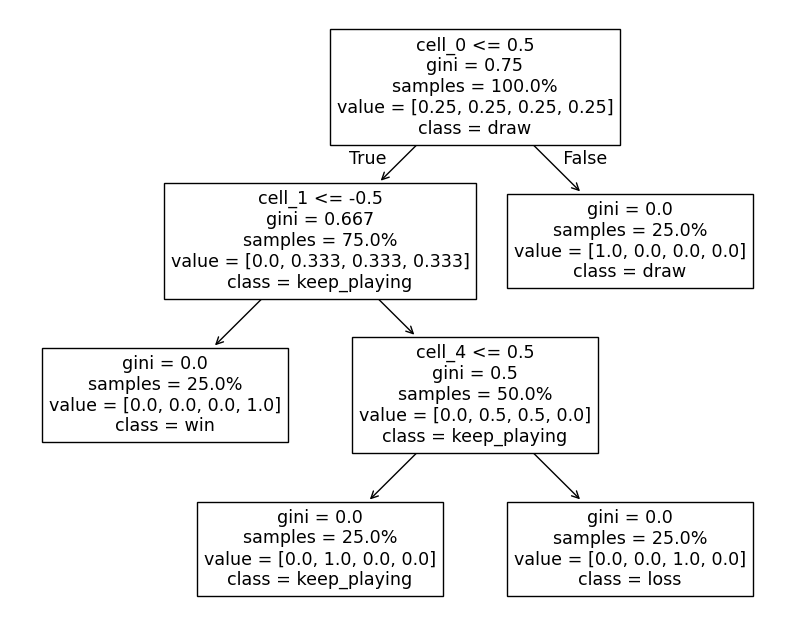

In [24]:
# Example Hexapawn board states (3x3)
X_hexapawn = [
    ['.', 'B', '.', '.', 'W', '.', '.', '.', '.'],  # Example state
    ['.', '.', '.', '.', 'W', '.', 'B', '.', '.'],  # Another state
    ['W', '.', '.', 'B', '.', '.', '.', 'W', '.'],  # Third state
    ['.', '.', '.', '.', '.', '.', '.', '.', '.'],  # Initial state
]
y_hexapawn = ['win', 'loss', 'draw', 'keep_playing']  # Labels for each state

# Encode the board
X_numeric_hexapawn = [[1 if cell == 'W' else -1 if cell == 'B' else 0 for cell in row] for row in X_hexapawn]

# Train the classifier
clf_hexapawn = DecisionTreeClassifier()
clf_hexapawn.fit(X_numeric_hexapawn, y_hexapawn)

# Visualize the tree
plt.figure(figsize=(10, 8))
tree.plot_tree(
    clf_hexapawn,
    feature_names=[f"cell_{i}" for i in range(9)],  # Adjust feature names based on board size
    class_names=clf_hexapawn.classes_,
    proportion=True
)
plt.show()
